In [7]:
#! The following code is intented only for illustration and cannot be run as a single script.

from os.path import isfile, join
from os import listdir
import numpy as np
#from orangecontrib.associate.fpgrowth import * 
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
from datetime import datetime
from sklearn.cluster import DBSCAN
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.backends.backend_pdf
from clickhouse_driver import connect
import time
import warnings
import os
warnings.filterwarnings("ignore")

Load ratio-csv

In [5]:
path = "/home/../twitter_results/"

files = [join(path, f) for f in listdir(path) if isfile(join(path, f))]

df = pd.DataFrame(columns=["timestamp", "value", "anomaly_score", "token"])

for file in files:
    df_ = pd.read_csv(file, delimiter=",") # , names=["timestamp", "value", "anomaly_score"])
    df_["token"] = file.split("-")[-1].split(".")[0]
    df = pd.concat((df, df_))

In [ ]:
path = "/home/florian/ADBC/NAB/results/adbc/realTweets/"

df = pd.DataFrame(columns=["timestamp", "value", "anomaly_score", "token"])

files = [join(path, f) for f in listdir(path) if isfile(join(path, f))]

for file in files:
    tmp = pd.read_csv(file, delimiter=",")
    tmp = tmp[["timestamp", "value", "anomaly_score"]]
    tmp["token"] = file.split("volume_")[-1].split(".")[0]
    df = pd.concat((df, tmp))

Plot densities of windows to determine threshold at $\mu+2\sigma$

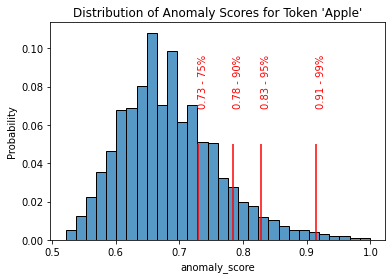

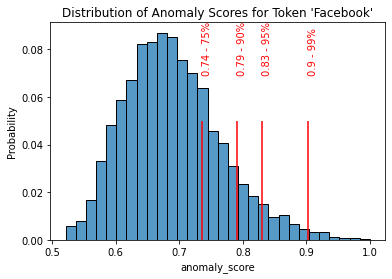

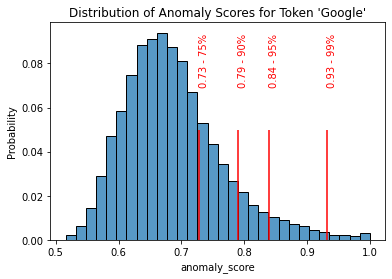

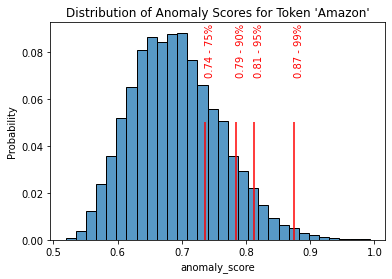

In [19]:
pdf = matplotlib.backends.backend_pdf.PdfPages("anomaly_score_distributions.pdf")
for token in df["token"].unique():
    fig = plt.figure()
    df_ = df[df["token"] == token]
    df_ = df_[df_["anomaly_score"] > 0.1]
    sns.histplot(data=df_, x="anomaly_score", bins=30, stat="probability")
    plt.title("Distribution of Anomaly Scores for Token '{}'".format(token))
    percentiles = [75, 90, 95, 99]
    for percentile in percentiles:
        threshold = np.percentile(df_["anomaly_score"], percentile)
        plt.vlines(threshold, 0, 0.05, "r")
        plt.text(threshold, 0.07, "{} - {}%".format(str(round(threshold, 2)), percentile), color="r", rotation="vertical")
    
    pdf.savefig(fig, bbox_inches='tight')
pdf.close()

Temporal Clustering

  0%|          | 0/4 [00:00<?, ?it/s]

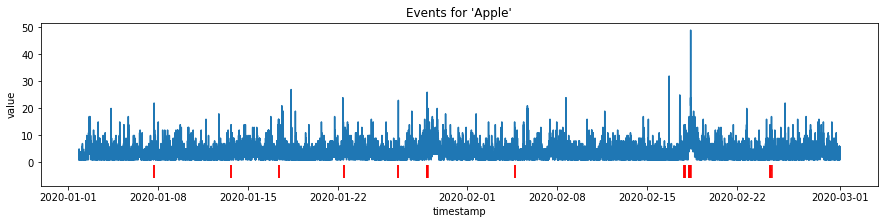

 25%|██▌       | 1/4 [00:01<00:05,  1.82s/it]

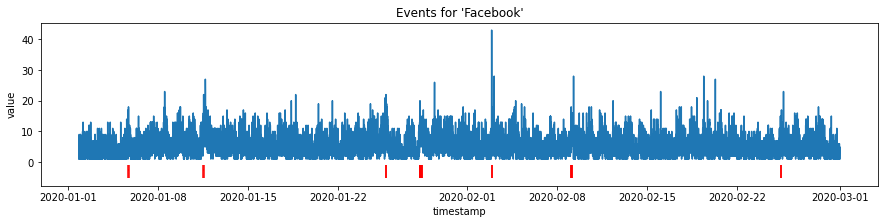

 50%|█████     | 2/4 [00:04<00:03,  1.98s/it]

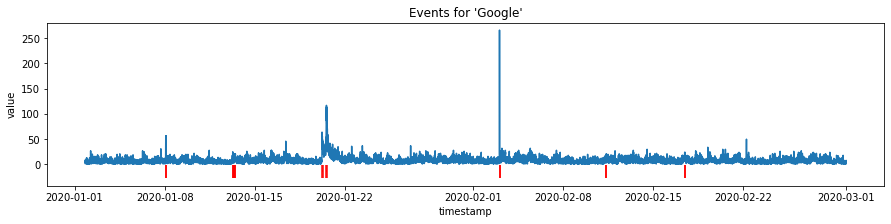

 75%|███████▌  | 3/4 [00:06<00:01,  1.94s/it]

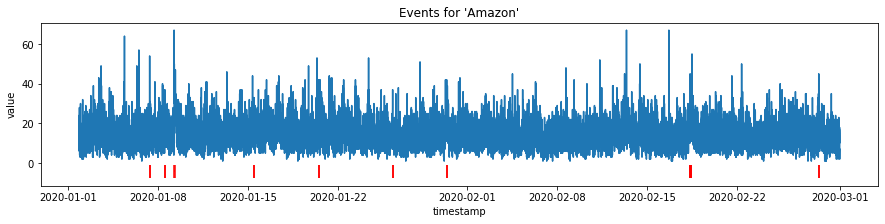

100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


In [9]:
pdf = matplotlib.backends.backend_pdf.PdfPages("events_temporal_clustering.pdf")
events = []

for token in tqdm(df["token"].unique()):
    
    # filter on timestamps where anomaly_score > threshold
    df_ = df[df["token"] == token]
    percentile = 99
    minSamples = 3
    threshold = np.percentile(df_["anomaly_score"], percentile)
    relevant_idx = np.where(df_["anomaly_score"] > threshold)[0]
    df_ = df_.iloc[relevant_idx]
    
    # convert string date to timestamp
    f = lambda n: int(time.mktime(datetime.strptime(n, "%Y-%m-%d %H:%M:%S").timetuple()))
    timestamps = df_["timestamp"].apply(lambda n: f(n))

    # temporal clustering
    ts = np.asarray(sorted(timestamps)).reshape(-1, 1)
    dbscan = DBSCAN(min_samples=minSamples, eps=max(900, minSamples*300)).fit(ts)
    labels = dbscan.labels_

    
    # any events reconstructed?
    if any(list(map(lambda n: n != -1, labels))):
        intervals = []
        for cluster in set(labels):
            if cluster == -1:
                continue
            relevant_ts = ts[np.where(labels == cluster)[0]]
            start = min(relevant_ts)[0]
            end = max(relevant_ts)[0]
            #print("Start: {}, End: {}, Duration: {}".format(start, end, end-start))
            intervals.append((start, end))

            # add event plus associated tweet ids to the events list for further processing later
            df_ = df[df["token"] == token]
            #tids = df[(df["token"] == token) & (df["ts"] >= start) & (df["ts"] <= end)]["tid"].to_list()
            event = (token, start, end)#, tids)
            events.append(event)


        # plot some token timelines + their extracted events
        fig = plt.figure(figsize=(15, 3))
        df_["value"] = df_["value"].astype(float)
        df_['timestamp'] = pd.to_datetime(df_['timestamp'], format='%Y-%m-%d %H:%M:%S')
        sns.lineplot(x="timestamp", y="value", data=df_)

        
        plt.title("Events for '{}'".format(token))

        # draw some reference lines
        for t1,t2 in intervals:
            t1 = datetime.fromtimestamp(t1)
            t2 = datetime.fromtimestamp(t2)
            y_size = df_["value"].max() / 10
            plt.vlines(t1, -1, - (1 + y_size), "r")
            plt.vlines(t2, -1, - (1 + y_size), "r")
            plt.hlines((1 + y_size) / -2, t1, t2, "r")
        
        plt.show()
        pdf.savefig(fig, bbox_inches='tight')

pdf.close()

Retrieve all relevant TIDs belonging to one Event and execute the following (Event Reconstruction) Code only on those tweets

In [11]:
conn = connect('clickhouse://<user>:<password>@127.0.0.1/paper')
cursor = conn.cursor()
verbose = 0

for token, start, end in events:
    print("------")
    start = datetime.fromtimestamp(start)
    end = datetime.fromtimestamp(end)

    print("Reporting Contextual Information for Token '{}' during the Event '{}'-'{}'".format(token, start, end))
    
    query = "SELECT strong_content, weak_content \
                FROM paper.annotations \
                WHERE tweet_time >= '{}' \
                and tweet_time < '{}' \
                and has(strong_content, '{}')".format(start, end, token)

    
    cursor.execute(query)
    D = cursor.fetchall()
      
    strong_content = []
    weak_content = []
    
    for s, w in D:
        try:
            s.remove(token)
        except:
            ...
        if len(s) > 0:
            strong_content.append(s)
            
        try:
            w.remove(token)
        except:
            ...
        if len(w) > 0:
            weak_content.append(w)

    # Frequent Itemsets for Strong Content
    te = TransactionEncoder()
    dataset = te.fit_transform(strong_content)
    
    df_s = pd.DataFrame(dataset, columns=te.columns_)
    frequent_itemsets = fpgrowth(df_s, min_support=0.1, use_colnames=True)
    try:
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
        print(rules)
    except:
        rules = None

    #print("Frequent Itemsets for Strong Content")
    print(frequent_itemsets)
    if verbose >= 1:
        print("Association Rules for Strong Content")
        print(rules)
    #else:
    #    print([set(x) for x in list(frequent_itemsets["itemsets"])])
    
    # Frequent Itemsets for Weak Content
    te = TransactionEncoder()
    dataset = te.fit_transform(weak_content)
    
    df_w = pd.DataFrame(dataset, columns=te.columns_)
    frequent_itemsets = fpgrowth(df_w, min_support=0.1, use_colnames=True, max_len=1)
    
    # (RuS)\S  
    max_support = 0.6
    frequent_itemsets = frequent_itemsets[frequent_itemsets["support"] < max_support]
    #print("Further relevant tokens:")
    print(frequent_itemsets)

    """
    print([set(x) for x in list(frequent_itemsets["itemsets"])])
    try:
        a = [set(x) for x in list(rules["antecedents"])]
        c = [set(x) for x in list(rules["consequents"])]
        rules["str"] = ["{} -> {}".format(aa, cc) for aa,cc in zip(a, c)]
        print(list(rules["str"]))
    except:
        ...
    """


cursor.close()
conn.close()

------
Reporting Contextual Information for Token 'Apple' during the Event '2020-01-07 16:20:00'-'2020-01-07 16:30:00'
  antecedents consequents  antecedent support  consequent support   support  \
0       (FBI)   (iPhones)            0.177419            0.112903  0.112903   
1   (iPhones)       (FBI)            0.112903            0.177419  0.112903   

   confidence      lift  leverage  conviction  
0    0.636364  5.636364  0.092872    2.439516  
1    1.000000  5.636364  0.092872         inf  
    support        itemsets
0  0.177419           (FBI)
1  0.112903       (iPhones)
2  0.338710    (Apple News)
3  0.112903  (FBI, iPhones)
    support  itemsets
0  0.142857    (have)
1  0.131868     (ask)
2  0.120879     (FBI)
3  0.120879  (unlock)
4  0.230769    (News)
------
Reporting Contextual Information for Token 'Apple' during the Event '2020-01-13 15:50:00'-'2020-01-13 16:00:00'
          antecedents        consequents  antecedent support  \
0            (Disney)          (Netflix)    

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []
    support  itemsets
0  0.200000     (FBI)
1  0.177778  (iPhone)
    support  itemsets
0  0.102273    (plan)
1  0.102273  (backup)
2  0.102273     (FBI)
3  0.193182    (have)
4  0.136364  (iPhone)
5  0.113636     (new)
6  0.136364   (apple)
7  0.113636   (start)
------
Reporting Contextual Information for Token 'Apple' during the Event '2020-01-26 16:00:00'-'2020-01-26 16:10:00'
          antecedents        consequents  antecedent support  \
0            (Disney)          (Netflix)            0.543860   
1           (Netflix)           (Disney)            0.561404   
2            (Amazon)           (Disney)            0.543860   
3            (Disney)           (Amazon)            0.543860   
4            (Amazon)          (Netflix)            0.543860   
5           (Netflix)           (Amazon)            0.561404   
6    (Amazon, Disn

  antecedents consequents  antecedent support  consequent support   support  \
0     (4Chan)      (Chan)            0.835821            0.835821  0.835821   
1      (Chan)     (4Chan)            0.835821            0.835821  0.835821   

   confidence      lift  leverage  conviction  
0         1.0  1.196429  0.137224         inf  
1         1.0  1.196429  0.137224         inf  
    support       itemsets
0  0.835821         (Chan)
1  0.835821        (4Chan)
2  0.835821  (4Chan, Chan)
Empty DataFrame
Columns: [support, itemsets]
Index: []
------
Reporting Contextual Information for Token 'Facebook' during the Event '2020-01-25 16:20:00'-'2020-01-25 17:05:00'
                        antecedents                     consequents  \
0                        (Whatsapp)                       (respect)   
1                         (respect)                      (Whatsapp)   
2                       (messenger)                       (respect)   
3                         (respect)              

45  0.128205          (LinkedIn, Instagram, Twitter, Tinder)
     support     itemsets
0   0.147368   (facebook)
1   0.315789         (be)
2   0.178947         (do)
3   0.178947       (have)
4   0.157895   (Whatsapp)
5   0.157895        (day)
6   0.147368    (respect)
7   0.147368        (ask)
8   0.147368   (kindness)
9   0.147368       (love)
10  0.147368  (messenger)
11  0.147368      (value)
12  0.136842      (Media)
13  0.189474   (LinkedIn)
14  0.200000  (Instagram)
15  0.136842     (Tinder)
16  0.157895    (Twitter)
------
Reporting Contextual Information for Token 'Facebook' during the Event '2020-01-28 07:45:00'-'2020-01-28 08:15:00'
       antecedents      consequents  antecedent support  consequent support  \
0  (consciousness)          (Islam)                0.12                0.12   
1          (Islam)  (consciousness)                0.12                0.12   

   support  confidence      lift  leverage  conviction  
0     0.12         1.0  8.333333    0.1056         inf

                                           antecedents  \
0                                               (Data)   
1                                                (job)   
2                                               (Data)   
3                                       (Data Science)   
4                                                (job)   
5                                       (Data Science)   
6                                          (Data, job)   
7                                 (Data, Data Science)   
8                                  (job, Data Science)   
9                                               (Data)   
10                                               (job)   
11                                      (Data Science)   
12                           (MenloParkCAUnitedStates)   
13                                      (Data Science)   
14                                              (Data)   
15                           (MenloParkCAUnitedStates)   
16            

                                          antecedents  \
0                       (DigitalWellbeingResolutions)   
1                                               (gno)   
2                       (DigitalWellbeingResolutions)   
3                                         (Sponsored)   
4                                         (Sponsored)   
5                                               (gno)   
6            (DigitalWellbeingResolutions, Sponsored)   
7                  (DigitalWellbeingResolutions, gno)   
8                                    (Sponsored, gno)   
9                       (DigitalWellbeingResolutions)   
10                                        (Sponsored)   
11                                              (gno)   
12     (DigitalWellbeingResolutions Google Sponsored)   
13     (DigitalWellbeingResolutions Google Sponsored)   
14     (DigitalWellbeingResolutions Google Sponsored)   
15  (DigitalWellbeingResolutions, DigitalWellbeing...   
16  (Sponsored, DigitalWellbein

                           antecedents  \
0                            (Jongdae)   
1                               (Chen)   
2                               (종대응원)   
3                               (종대응원)   
4                      (Jongdae, 종대응원)   
5                         (Chen, 종대응원)   
6                               (종대응원)   
7                              (우리_종대)   
8                               (종대응원)   
9                              (우리_종대)   
10                             (우리_종대)   
11                       (Chen, 우리_종대)   
12                        (Chen, 종대응원)   
13                       (우리_종대, 종대응원)   
14                             (우리_종대)   
15                              (종대응원)   
16                    (Jongdae, 우리_종대)   
17                     (Jongdae, 종대응원)   
18                       (우리_종대, 종대응원)   
19                             (우리_종대)   
20                              (종대응원)   
21                       (Chen, 우리_종대)   
22                    (Jongdae, 우리

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []
    support   itemsets
0  0.815622  (Googles)
Empty DataFrame
Columns: [support, itemsets]
Index: []
------
Reporting Contextual Information for Token 'Google' during the Event '2020-01-20 12:25:00'-'2020-01-20 15:45:00'
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []
    support   itemsets
0  0.726083  (Googles)
Empty DataFrame
Columns: [support, itemsets]
Index: []
------
Reporting Contextual Information for Token 'Google' during the Event '2020-02-03 00:55:00'-'2020-02-03 01:10:00'
Empty DataFrame
Columns: [support, itemsets]
Index: []
Empty DataFrame
Columns: [support, itemsets]
Index: []
------
Reporting Contextual Information for Token 'Google' during the Event '2020-02-11 07:55:00'-'2020-02-11 08:30:00'
Empty DataFrame
Columns: [

Empty DataFrame
Columns: [support, itemsets]
Index: []
    support itemsets
0  0.126984     (be)
------
Reporting Contextual Information for Token 'Amazon' during the Event '2020-01-26 05:20:00'-'2020-01-26 05:30:00'
         antecedents        consequents  antecedent support  \
0  (RepublicDay2020)        (Bolsonaro)            0.513158   
1        (Bolsonaro)  (RepublicDay2020)            0.486842   

   consequent support   support  confidence      lift  leverage  conviction  
0            0.486842  0.486842    0.948718  1.948718  0.237015   10.006579  
1            0.513158  0.486842    1.000000  1.948718  0.237015         inf  
    support                      itemsets
0  0.513158             (RepublicDay2020)
1  0.486842                   (Bolsonaro)
2  0.486842  (RepublicDay2020, Bolsonaro)
     support       itemsets
0   0.359375      (destroy)
1   0.351562            (s)
2   0.351562  (responsible)
3   0.304688        (guest)
4   0.304688  (RepublicDay)
5   0.304688        (Ch

In [ ]:
[set(x) for x in list(rules["antecedents"])]